<a href="https://colab.research.google.com/github/balvantchauhan/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Problem, We focuses on the task of image segmentation, using a modified U-Net

### What is image segmentation?

In an image classification task the network assign a label(or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case we will want to assign a class to each pixel of the image. This task as known as segmentation. A segmentation model returns much more detail information about the image. Image segmentation has many application in medical imaging, self-driving cars and satellite imaging to name a few.


In this segmentation problem we use the Oxford-IIIT Pet Dataset, The dataset consist of images of 37 pet breeds, with 200 images pre breed. Each images includes the corresponding labels, and pixel-wise masks. The mask are class-labels for each pixel.

Each pixel is given one of three categories.

- Class 1 : Pixel belonging to pet.
- Class 2 : Pixel bordering the pet
- Class 3 : None of the above / Surrounding pixel.

### Importing libraries

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback, TensorBoard
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime

### Other Params

In [ ]:
IMG_SIZE = (128, 128)
IMG_CHANNELS = 3
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 150
VAL_SUBSPLITS = 5

### Download the Oxford-IIT Pets dataset

The dataset is available from TensorFlow Dataset. The segmentation masks are included in version 3+.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In addition, the image color values are normalize to the [0, 1]' range. Finally, as mentioned above the pixels in the segmentation mask ar labeled either{1, 2, 2}`. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
  input_mask = tf.image.resize(datapoint['segmentation_mask'], IMG_SIZE)

  input_image , input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

The dataset already contains the required splits of test and train and so continue to use the same split.

In [ ]:
TRAIN_LENGHT = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGHT // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class perform a simple augmentation of randoly-flipping an image

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they will make the same random changes.
    self.augment_inputs = preprocessing.RandomFlip(mode='horizontal', seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode='horizontal', seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images = test_images.batch(BATCH_SIZE)

Take a look at an image example and it's corresponding mask from the dataset

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

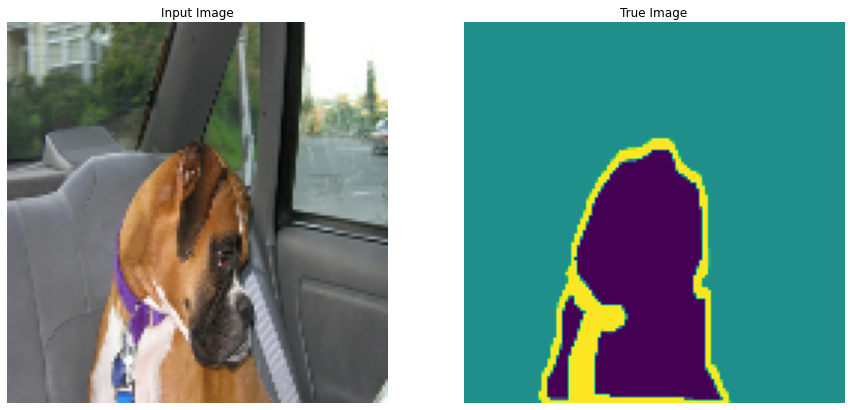

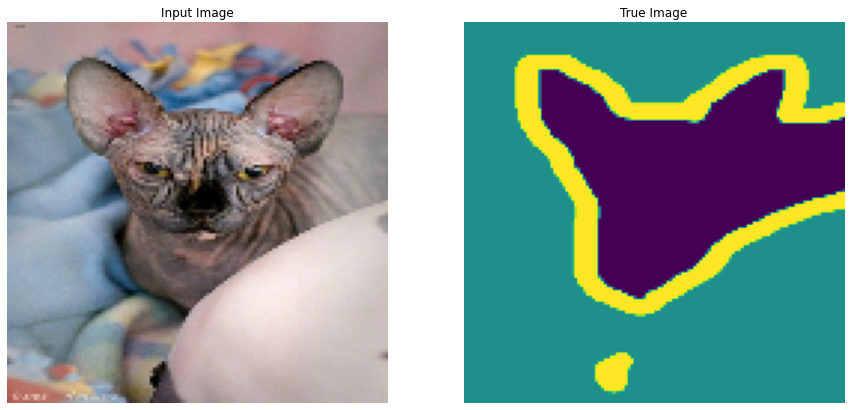

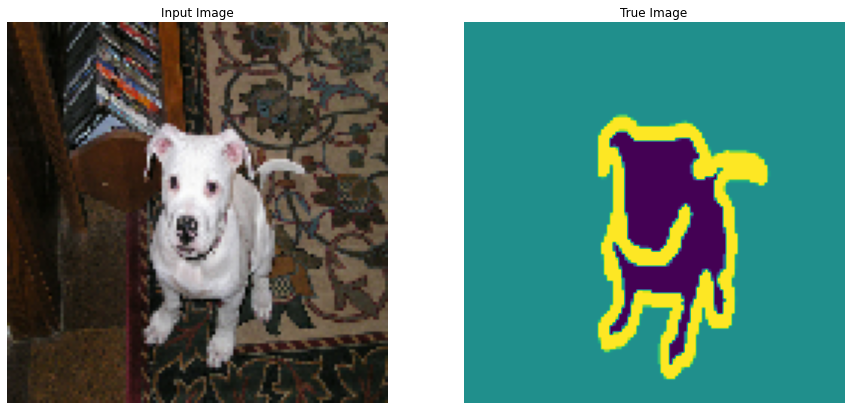

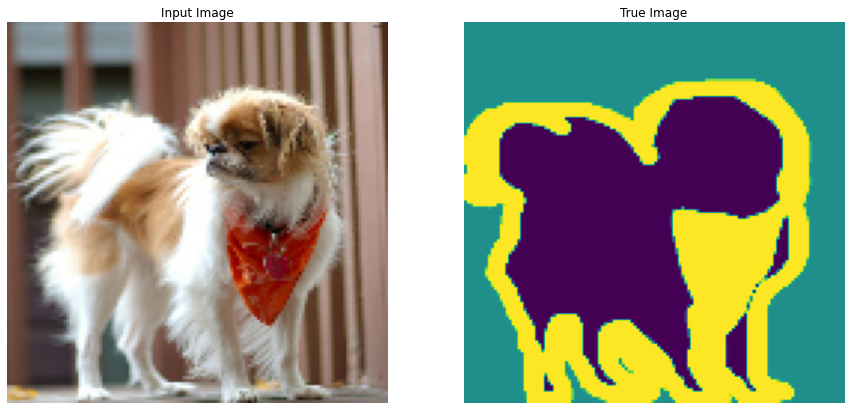

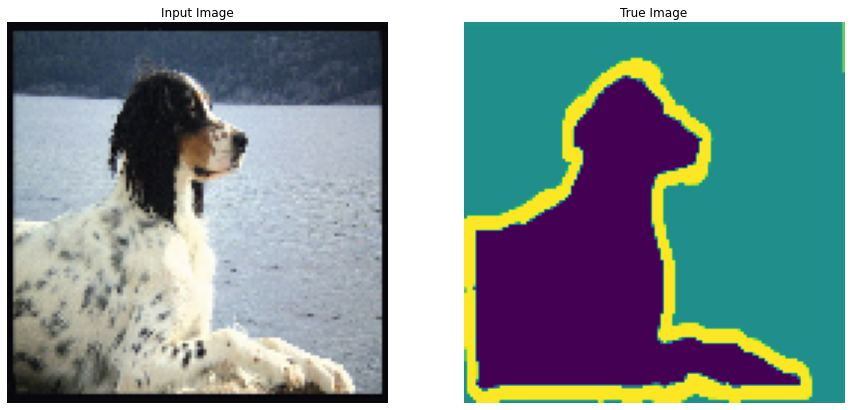

In [ ]:
for images, masks in train_batches.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Define the model

In [ ]:
def unet_model():
  IMG_SHAPE = IMG_SIZE + (3, ) 
  inputs = Input(IMG_SHAPE)

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D((2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #### Expansive path

  u6 = Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(3, (1, 1), activation='softmax')(c9)
  return Model(inputs=inputs, outputs=c9)

In [ ]:
model = unet_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

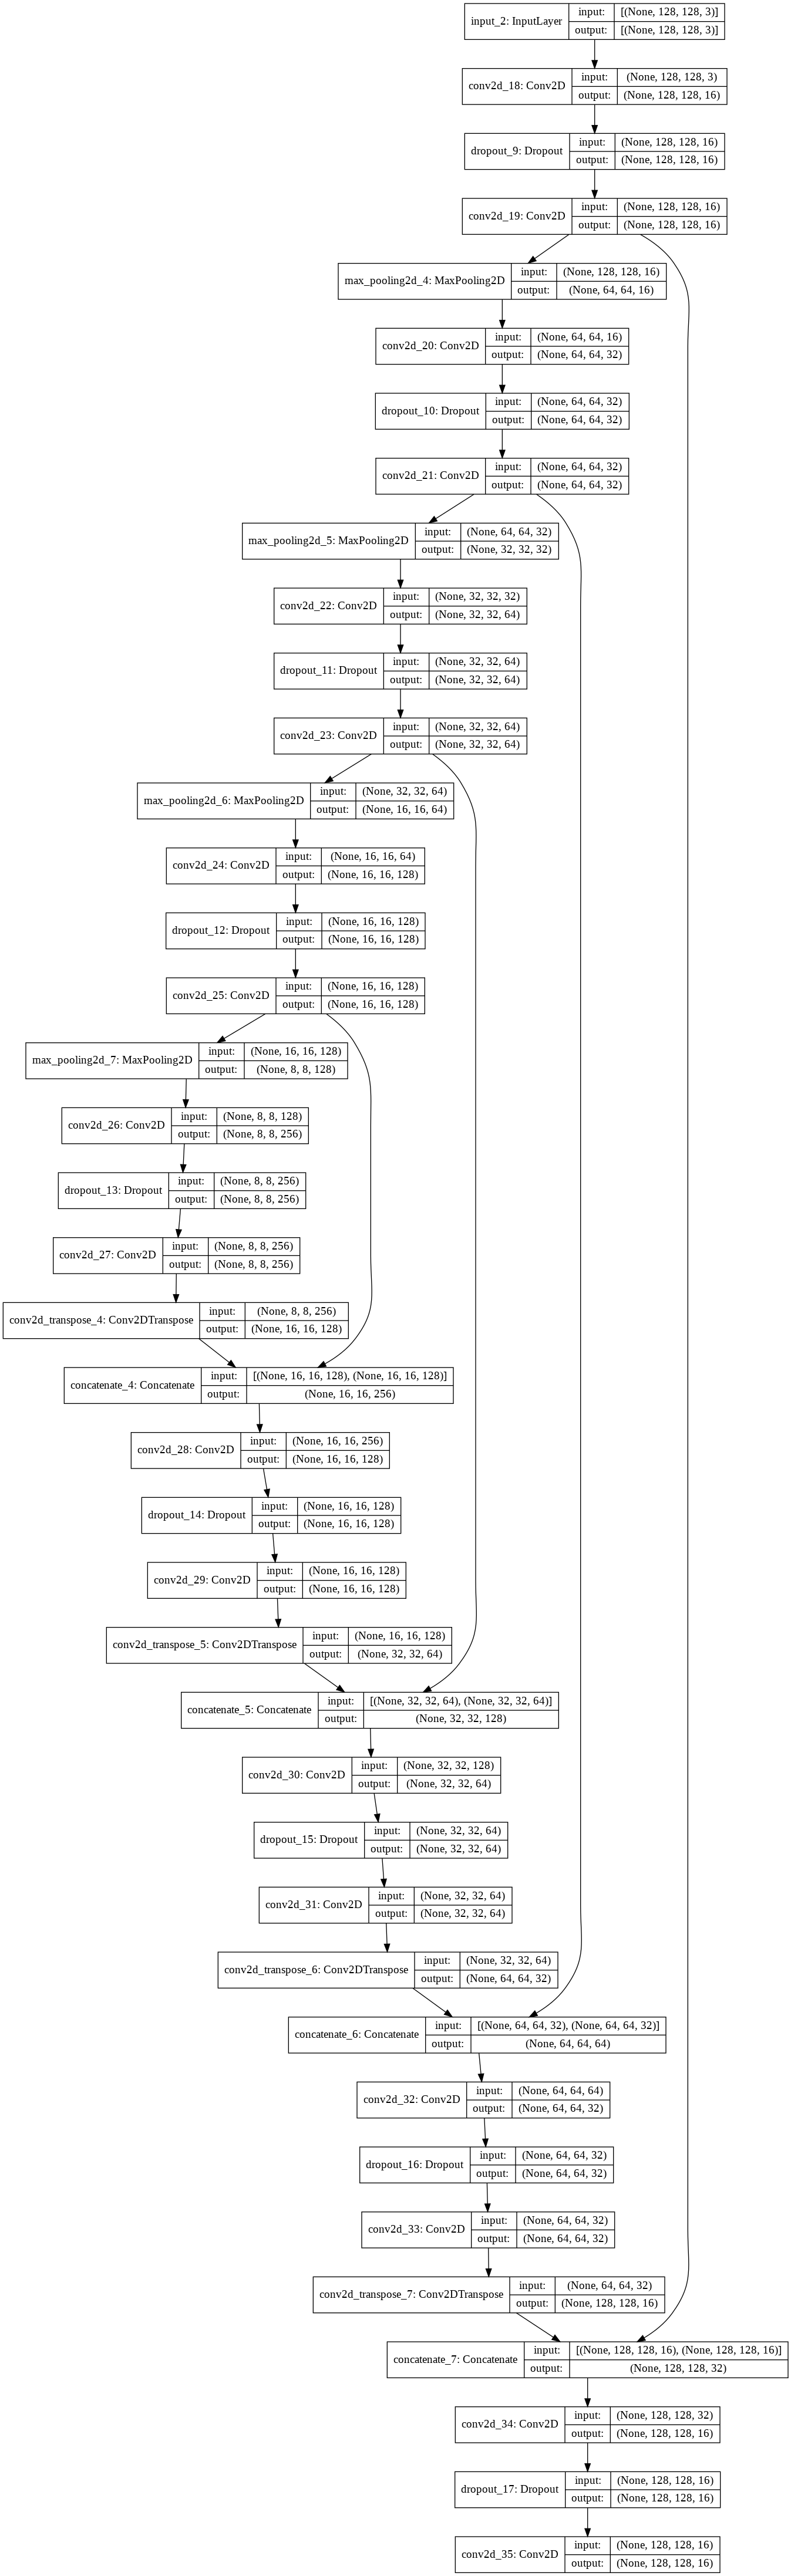

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  #print(pred_mask.shape)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #print(pred_mask.shape)
  pred_mask = pred_mask[..., tf.newaxis]
  #print(pred_mask.shape)
  return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    print(sample_image.shape, 'Hi')
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    #print(sample_image.shape, 'Hi')
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    #print(pred_mask.shape, 'Hello')
    display([sample_image, sample_mask, create_mask(pred_mask)])

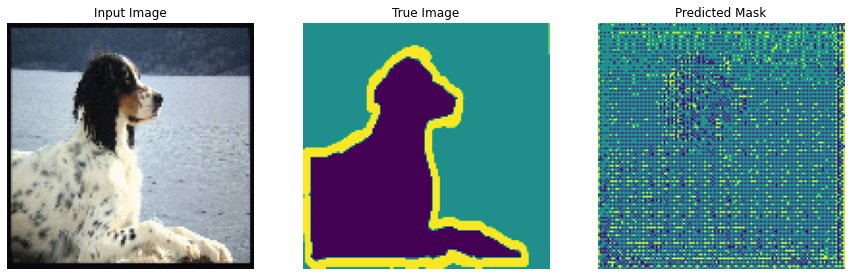

In [ ]:
show_predictions()

The callback define below is used to observe how the model improves while it is training.

In [ ]:
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


Define TensorBoard callback here

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,
                                   histogram_freq=1) # Enable histogram computation for every epoch.

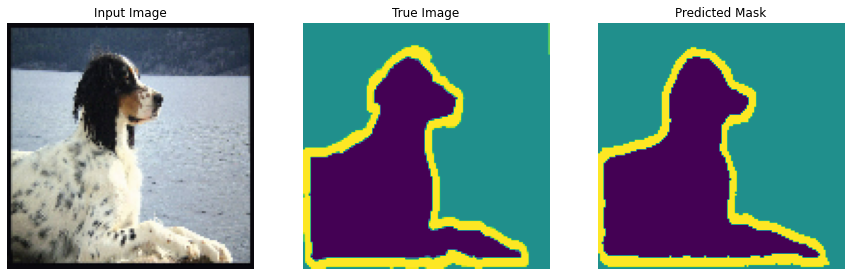


Sample Prediction after epoch 150



In [ ]:
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), tensorboard_callback])

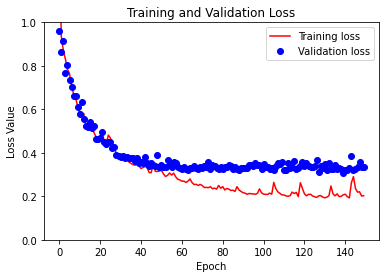

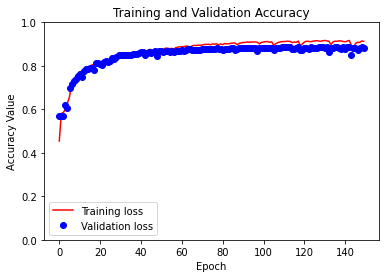

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()



plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training loss')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions

Now make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

(128, 128, 3) Hi


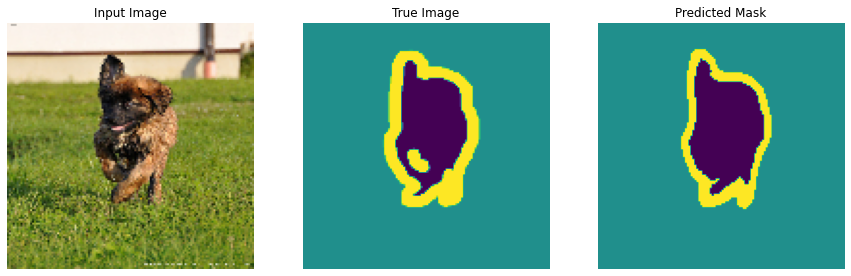

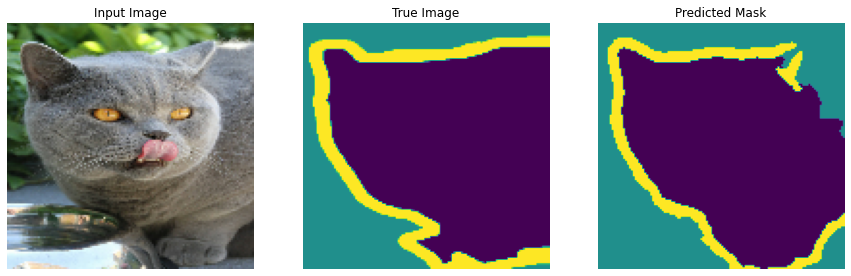

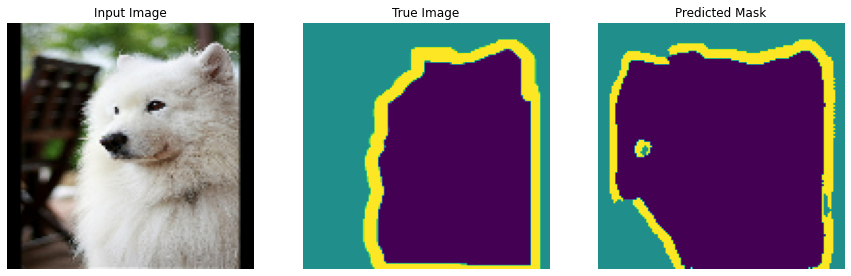

In [ ]:
show_predictions(test_batches, 3)